## Exercises
- Discover **users** who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

- Can you label students who are viewing both the web dev and data science curriculum? 
- Can you label students by the program they are in? 
- Can you label users by student vs. staff? 
- What are Zach, Maggie, Faith, and Ryan's ids?

#### Prepare Environment

In [24]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

#### Acquire
- Data: curriculum-access.txt

In [25]:
df_orig = pd.read_csv('anonymized-curriculum-access.txt',          
                      engine='python',
                      header=None,
                      index_col=False,
                      sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                      na_values='"-"',
)

df_orig.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


**Takeaways**
- Need to rename the columns: 
    1. Columns 0 and 1 are timestamp. I need to combine them together and set as index
    2. column 2 is the request method
    3. What are column 3 and 4? 
        - column 3: student id
        - column 4: cohort id
    4. column 5 are ip address. 

In [26]:
# Rename the columns

df_orig.columns = ['date', 'time', 'request_method', 'user_id', 'cohort_id', 'ip']
df_orig.head()

,date,time,request_method,student_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [27]:
# Create a new column timestampe

df_orig['timestamp'] = df_orig.date.str.cat(df_orig.time, sep=' ')
df_orig.head()

,date,time,request_method,student_id,cohort_id,ip,timestamp
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [28]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            719459 non-null  object 
 1   time            719459 non-null  object 
 2   request_method  719458 non-null  object 
 3   student_id      719459 non-null  int64  
 4   cohort_id       674619 non-null  float64
 5   ip              719459 non-null  object 
 6   timestamp       719459 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 38.4+ MB


In [29]:
# Convert to dtype of datetime

df_orig.timestamp = pd.to_datetime(df_orig.timestamp)
df_orig.head()

,date,time,request_method,student_id,cohort_id,ip,timestamp
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [30]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719459 entries, 0 to 719458
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            719459 non-null  object        
 1   time            719459 non-null  object        
 2   request_method  719458 non-null  object        
 3   student_id      719459 non-null  int64         
 4   cohort_id       674619 non-null  float64       
 5   ip              719459 non-null  object        
 6   timestamp       719459 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 38.4+ MB


In [31]:
# Set the data as the index

df = df_orig.set_index('timestamp').sort_index()
df.head()

,date,time,request_method,student_id,cohort_id,ip
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [32]:
# Drop columns date and time

df.drop(columns=['date', 'time'], inplace=True)
df.head()

,request_method,student_id,cohort_id,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


#### Any missing values? 

In [33]:
df.isnull().sum(axis=0) # There are 44840 missing values in cohort_id

request_method        1
student_id            0
cohort_id         44840
ip                    0
dtype: int64

### Summarize the data

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719459 entries, 2018-01-26 09:55:03 to 2020-11-02 16:48:47
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   request_method  719458 non-null  object 
 1   student_id      719459 non-null  int64  
 2   cohort_id       674619 non-null  float64
 3   ip              719459 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.4+ MB


In [35]:
# How many unique values in column student id?
df['student_id'].nunique() # There are 787 unique values, for now it is labeled as student_id

787

In [36]:
# Which student id has the highest number of accessing?
df['student_id'].value_counts(dropna=False).head()

11     14870
64     14444
53     10874
1       6440
314     6419
Name: student_id, dtype: int64

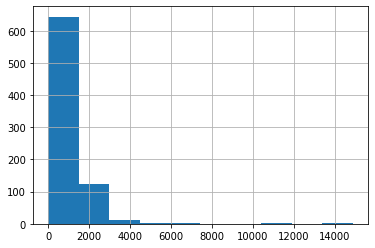

In [37]:
# Viz the distribution of the accessing numbers
df['student_id'].value_counts(dropna=False).hist()

In [49]:
# Take a look at the student id 11
df[df.student_id == 11]

,request_method,student_id,cohort_id,ip
timestamp,,,,
2018-01-26 10:14:47,/,11,1.0,97.105.19.61
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61
2018-01-26 11:46:29,appendix/further-reading/javascript/hoisting.html,11,1.0,97.105.19.61
2018-01-26 11:46:39,appendix,11,1.0,97.105.19.61
...,...,...,...,...
2020-11-02 16:22:12,nlp/explore,11,28.0,76.185.145.231
2020-11-02 16:42:02,anomaly-detection/overview,11,28.0,76.185.145.231
2020-11-02 16:42:02,anomaly-detection/AnomalyDetectionCartoon.jpeg,11,28.0,76.185.145.231


In [50]:
# Take a look at the student id 
df[df.student_id == 64]

,request_method,student_id,cohort_id,ip
timestamp,,,,
2018-01-29 13:50:57,/,64,1.0,97.105.19.61
2018-01-29 13:51:00,mkdocs/search_index.json,64,1.0,97.105.19.61
2018-01-29 13:51:04,mysql/users,64,1.0,97.105.19.61
2018-01-30 10:13:09,/,64,1.0,97.105.19.61
2018-01-30 10:13:12,spring,64,1.0,97.105.19.61
...,...,...,...,...
2020-10-29 16:59:30,mysql/group-by,64,28.0,76.25.25.4
2020-10-29 16:59:38,mysql/aliases,64,28.0,76.25.25.4
2020-10-29 16:59:58,mysql/group-by,64,28.0,76.25.25.4


In [54]:
# Take a look at the student id 
df[df.student_id == 53]

,request_method,student_id,cohort_id,ip
timestamp,,,,
2018-01-28 18:48:19,index.html,53,14.0,67.10.161.55
2018-01-28 18:48:24,html-css,53,14.0,67.10.161.55
2018-01-28 18:49:20,javascript-i,53,14.0,67.10.161.55
2018-01-28 18:49:23,javascript-i/conditionals,53,14.0,67.10.161.55
2018-01-28 18:50:41,javascript-i/conditionals,53,14.0,67.10.161.55
...,...,...,...,...
2020-11-02 09:09:53,examples/javascript/dom-query-js.html,53,28.0,67.10.174.56
2020-11-02 15:27:42,appendix/slides,53,28.0,67.10.174.56
2020-11-02 16:09:40,index.html,53,28.0,67.10.174.56


In [38]:
# How many unique values in column 4?
df.cohort_id.nunique() # 40 unique values in cohort id

40

In [39]:
# Which cohort id has the highest counts of accessing?

df['cohort_id'].value_counts(dropna=False).head(5)

28.0    60315
NaN     44840
33.0    40168
29.0    37548
53.0    36047
Name: cohort_id, dtype: int64

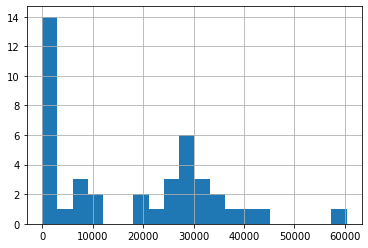

In [48]:
# Viz the distribution of the counts of accessing by counts

df['cohort_id'].value_counts(dropna=False).hist(bins=20)